# Image Pre Processing


See image pre-processing decisions and notes

Preprocesses images loaded from the class balanced data set.
Uses previsouly extracted class_balanced_image_ids.csv file to ginf image ids that beling to balanced classes



    Image preprocessing issues and how addressed:

    1) Crop the image: No. Images are already focused on the lesion, are already centered and tightly cropped dermatoscopic images of the lesions. For simple feature extraction, additional cropping may remove useful context. Decision: no cropping.

    2) Center the image: images are already centered. Decision: No.

    3) Presence of hairs - can make mode mistake hairs as lesion boundaries or features. Decision: Hairs need to be used. Used ‘dull razor’ approach, as a preprocessing step; the approach detects hair using morphological operations and inpaints (fills) the detected regions. Use cv2 library (blackout filtering to find hair, threshold to detect hair, inpaint to remove hair)

    4) Handling scale markers on some images: if scale markers are present in a consistent region, that region can be cropped off. Scale markers do impact simple feature extraction e.g. for histogram bins, texture patterns. Decision: mask scale markers using  edge detector such as Canny.
    5) Resize all images to a fixed shape 224,224

    6) Gaussian blur as part of reimaging (Prof Hany's recommendation) to reduce noise? No, since blurr may reduce color variance and flatten histogrtam peaks for color histograms, may smoot edges and weaken gradients for Histogram of Oriented Gradience (HOG), remove sharp transitions for edge detection. 


    Summary: No crop, no center, remove hairs, mask scale, resize to 224 x 224. No Gaussian blur.


# Class Imbalance addressal and other notes:

    Approach splits train/ test 85/10
    Preprocesses images for hair removal, scale mark removal *using canny, resize images to 224 x 224
    Generate hog, hsv, lbp, hog+hsv, hog + hsv + lbp features, store them as notebook variables.
    Generate Y_encoded class labels . store them as notebook variables.

    Above features and Y_encoded labels will feed into pipeline and training

    First stratify split train / test, 85/10 on feature array e.g. X_hog and Y_encoded labels. Yields train df, test_df
    Stratify-K-fold  split train df, 5 splits. Yields training folds and validation folds
    Apply over sampling to ONLY the train folds, and NOT the validation fold (this makes validation fold mirror real world class imbalance, and improves generalizability). 
        Note: we are using only oversampling and no undersampling. Using undersampling throws away lots of use ful data. 
| Strategy                         | Pros                                           | Cons                                             | Overfitting Risk | Generalization |
| -------------------------------- | ---------------------------------------------- | ------------------------------------------------ | ---------------- | -------------- |
| **Oversampling only**            | Keeps all original data; balances rare classes | Can overfit if it duplicates too many samples    | 🟡 Moderate      | ✅ Good         |
| **Oversampling + Undersampling** | Balances perfectly; same count per class       | **Throws away data** from majority classes → ⛔   | 🔴 High          | ❌ Poor         |
| **Undersampling only**           | Faster training                                | Loses diversity; not suitable for small datasets | 🔴 High          | ❌ Poor         |


In [1]:
# ! pip install imbalanced-learn

In [2]:
from imblearn.over_sampling import RandomOverSampler
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage import exposure
import numpy as np
# ---------------------- Imports ----------------------
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")

In [3]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow_datasets as tfds

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

import keras
import keras_tuner as kt

from keras import layers, models
from keras.optimizers import Adam
from tensorflow.keras import layers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.metrics import confusion_matrix

import joblib

# shap
#import shap

import openpyxl

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
import re
from sklearn.decomposition import PCA

import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


random.seed(42)


In [4]:
def whoAmI(img):
    """
    Prints dtype, min, max, mean, height, and width of an image.
    """
    print(f"dtype     : {img.dtype}")
    print(f"min       : {np.min(img):.4f}")
    print(f"max       : {np.max(img):.4f}")
    print(f"mean      : {np.mean(img):.4f}")
    print(f"shape     : {img.shape}")
    if img.ndim == 2:
        print(f"height    : {img.shape[0]}")
        print(f"width     : {img.shape[1]}")
    elif img.ndim == 3:
        print(f"height    : {img.shape[0]}")
        print(f"width     : {img.shape[1]}")
        print(f"channels  : {img.shape[2]}")

#VS - II helpful functions

# summarizes a data frame in a printer friendly way
def summarize_dataframe(df):
    summary = pd.DataFrame({
        'Column Name': df.columns,
        'Data Type': df.dtypes.values,
        'Null Count': df.isnull().sum().values,
        'Non-Null Count': df.notnull().sum().values,
        'Unique Count': df.nunique().values
    })
    return summary

def plot_training_history(history):
    """
    Plots training and validation loss & accuracy from a Keras history object.

    Parameters:
    - history: Keras history object from model.fit()
    """

    epochs = range(1, len(history.history['loss']) + 1)

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']


    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(epochs, train_loss, label='Training Loss', color='blue', linestyle='-')
    ax[0].plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, train_acc, label='Training Accuracy', color='blue', linestyle='-')
    ax[1].plot(epochs, val_acc, label='Validation Accuracy', color='red', linestyle='--')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [5]:
# ---------------------- Hair Removal ----------------------
def remove_hairs(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, thresh = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    result = cv2.inpaint(img, thresh, 1, cv2.INPAINT_TELEA)
    return result


# ---------------------- Scale Marker Masking ----------------------
def mask_scale_markers(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h > 500 and (w/h > 5 or h/w > 5):
            img[y:y+h, x:x+w] = 0
    return img


# ---------------------- Combined Preprocessing ----------------------
def preprocess_image(img):
    img_no_hair = remove_hairs(img)
    img_clean = mask_scale_markers(img_no_hair)
    return img_clean


# ---------------------- Preprocess All Images ----------------------
def preprocess_all_images_to_array(df, image_dir, resize_shape=(224, 224)):
    images, labels, image_ids = [], [], []
    for _, row in df.iterrows():
        image_id = row['image_id']
        label = row['dx']
        image_path = os.path.join(image_dir, f"{image_id}.jpg")
        if os.path.exists(image_path):
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = preprocess_image(img)
            img = cv2.resize(img, resize_shape)
            images.append(img)
            labels.append(label)
            image_ids.append(image_id)
    return np.array(images), labels, image_ids


# ---------------------- Feature Extraction ----------------------
def extract_hog_features_from_array(image_array):
    """
    Extract HOG features from a list or array of RGB images.
    Converts each image to grayscale before computing HOG.
    
    Returns:
        hog_features (np.ndarray): shape (num_images, num_features_per_image)
    """
    hog_features = []
    hog_images = []

    for img in image_array:
        gray_img = rgb2gray(img)  # Convert to grayscale
        features, hog_img = hog(
            gray_img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            visualize=True
        )
        hog_features.append(features)

        hog_img_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))
        hog_images.append(hog_img_rescaled)

    hog_features = np.array(hog_features)
    return hog_features


def compute_hsv_histogram(img, h_bins=16, s_bins=8, v_bins=8):
    """
    Compute a normalized HSV color histogram from an RGB image.
    
    Args:
        img (np.ndarray): RGB image.
        h_bins, s_bins, v_bins: Number of bins for H, S, and V channels.
    
    Returns:
        np.ndarray: Flattened and normalized HSV histogram.
    """
    # Convert from RGB to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Compute 3D histogram
    hist = cv2.calcHist(
        [hsv], [0, 1, 2], None,
        [h_bins, s_bins, v_bins],
        [0, 180, 0, 256, 0, 256]
    )

    # Normalize and flatten
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_hsv_features_from_array(image_array, bins=(16, 8, 8)):
    """
    Compute HSV histogram features for a list/array of RGB images.
    
    Args:
        image_array (list or np.ndarray): List of RGB images (preprocessed).
        bins (tuple): Bin sizes for (H, S, V).
    
    Returns:
        np.ndarray: Array of shape (num_images, num_features).
    """
    h_bins, s_bins, v_bins = bins
    hsv_color_hist_features = np.array([
        compute_hsv_histogram(img, h_bins, s_bins, v_bins) for img in image_array
    ])
    return hsv_color_hist_features

def compute_lbp_features(img, radius=1, n_points=8, method='uniform'):
    """
    Compute a normalized LBP histogram from a grayscale version of the RGB image.
    
    Args:
        img (np.ndarray): RGB image.
        radius (int): Radius of circle.
        n_points (int): Number of sampling points.
        method (str): LBP method ('uniform', 'default', etc.).
    
    Returns:
        np.ndarray: Normalized LBP histogram (1D feature vector).
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Compute LBP image
    lbp = local_binary_pattern(gray, n_points, radius, method=method)
    
    # Number of bins = number of unique patterns
    n_bins = int(lbp.max() + 1)
    
    # Compute normalized histogram
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    
    return hist

def extract_lbp_features_from_array(image_array, radius=1, n_points=8, method='uniform'):
    """
    Apply LBP feature extraction to an array of RGB images.
    
    Args:
        image_array (list/np.ndarray): List of RGB images.
        radius (int): Radius for LBP.
        n_points (int): Number of points for LBP.
        method (str): LBP method.
    
    Returns:
        np.ndarray: Array of LBP histograms.
    """
    lbp_features = np.array([
        compute_lbp_features(img, radius, n_points, method) for img in image_array
    ])
    return lbp_features


# ---------------------- Apply Feature Extraction ----------------------
def extract_features_all(images, extractor_func):
    features = []
    for img in images:
        f = extractor_func(img)
        features.append(f)
    return np.array(features)


# ---------------------- Combine Features ----------------------
def combine_features(*feature_arrays):
    return np.hstack(feature_arrays)


# ---------------------- Encode Labels ----------------------
def encode_labels(raw_labels):
    le = LabelEncoder()
    y_encoded = le.fit_transform(raw_labels)
    return y_encoded, le


# ---------------------- Train-Test Split ----------------------
def split_train_test_stratified(df, label_col='dx', test_size=0.15, random_state=42):
    train_df, test_df = train_test_split(df, test_size=test_size,
                                         stratify=df[label_col], random_state=random_state)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)


# ---------------------- Stratified K-Fold ----------------------
def get_kfold_splits(train_df, n_splits=5, label_col='dx', random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    folds = []
    for train_idx, val_idx in skf.split(train_df, train_df[label_col]):
        train_fold = train_df.iloc[train_idx].reset_index(drop=True)
        val_fold = train_df.iloc[val_idx].reset_index(drop=True)
        folds.append((train_fold, val_fold))
    return folds


# ---------------------- Imbalance Fix ----------------------
#from imblearn.over_sampling import RandomOverSampler

def balance_train_fold(X, y, oversample_strategy='minority'):
    """
    Balances the training fold using only oversampling.

    Args:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Labels.
        oversample_strategy (str or dict): Sampling strategy for oversampling. 
            Default is 'minority'.

    Returns:
        X_bal (np.ndarray): Oversampled feature matrix.
        y_bal (np.ndarray): Oversampled labels.
    """
    ros = RandomOverSampler(sampling_strategy=oversample_strategy, random_state=42)
    X_bal, y_bal = ros.fit_resample(X, y)
    return X_bal, y_bal

# ---------------------- Model Training & Evaluation ----------------------
def train_and_evaluate_fold(X_bal, y_bal, X_val, y_val):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_bal, y_bal)
    y_pred = clf.predict(X_val)
    print(classification_report(y_val, y_pred))
    return clf

def final_test_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))


To run full pipeline
| Argument        | Description                                                      | Example Value                       |
| --------------- | ---------------------------------------------------------------- | ----------------------------------- |
| `X`             | Feature matrix (`np.ndarray`), shape = `(n_samples, n_features)` | Extracted features like HOG+HSV+LBP |
| `y`             | Encoded labels (`np.ndarray`), shape = `(n_samples,)`            | Integer-encoded skin lesion labels  |
| `label_encoder` | A fitted `LabelEncoder` object for mapping back to class names   | Fitted on `raw_labels`              |


In [6]:
def run_full_pipeline(X, y, label_encoder, n_splits=5, random_state=42):
    """
    Run the full training and evaluation pipeline:
    - Stratified train-test split
    - Stratified K-Fold cross-validation on training set
    - Oversampling on each training fold
    - Train RandomForest classifier
    - Evaluate on validation fold and final test set

    Returns:
        df_report_test (pd.DataFrame): classification report on the final test set.
    """
    # Step 1: Stratified Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.15, stratify=y, random_state=random_state
    )

    # Step 2: Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold = 1
    best_model = None
    best_val_f1 = 0.0

    for train_idx, val_idx in skf.split(X_train, y_train):
        print(f"\n============== Fold {fold} ==============")
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Step 3: Oversampling only
        ros = RandomOverSampler(sampling_strategy='minority', random_state=random_state)
        X_tr_bal, y_tr_bal = ros.fit_resample(X_tr, y_tr)

        # Step 4: Train classifier
        clf = RandomForestClassifier(class_weight='balanced', random_state=random_state)
        clf.fit(X_tr_bal, y_tr_bal)

        # Step 5: Evaluate on validation fold
        y_val_pred = clf.predict(X_val)
        report_val = classification_report(y_val, y_val_pred, output_dict=True)
        val_f1 = report_val["weighted avg"]["f1-score"]
        print(f"Validation Weighted F1 Score: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model = clf

        fold += 1

    # Step 6: Evaluate best model on test set
    print("\n================ Final Test Evaluation ================")
    y_test_pred = best_model.predict(X_test)
    report_test = classification_report(
        y_test, y_test_pred, target_names=label_encoder.classes_, output_dict=True
    )
    df_report_test = pd.DataFrame(report_test).transpose().round(3)

    return df_report_test


----


In [7]:
DATA_DIR = '/Users/vishalsaxena/Documents/BERKMIDS2024ROOT/09MIDSCourses/MIDS281CompVision/281_Final_Project/281_FP_Factory/dataset/skin-cancer-mnist-ham10000/'
DATA_DIR_IMAGES = DATA_DIR + '/HAM10000_images/'

metadata_csv = '/Users/vishalsaxena/Documents/BERKMIDS2024ROOT/09MIDSCourses/MIDS281CompVision/281_Final_Project/281_FP_Factory/dataset/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'

df = pd.read_csv(metadata_csv)
print(df.head())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [8]:


# Step 1: Preprocess images
processed_images, raw_labels, image_ids = preprocess_all_images_to_array(df, image_dir=DATA_DIR_IMAGES)

# Step 2: Feature Extraction
X_hog = extract_hog_features_from_array(processed_images)
print("extracted features: hog")
X_hsv = extract_hsv_features_from_array(processed_images)
print("extracted features: hsv")
X_lbp = extract_lbp_features_from_array(processed_images)
print("extracted features: lbp")

# Step 3: Feature Combinations
X_hog_hsv = np.hstack([X_hog, X_hsv])
print("extracted features: hog + hsv")
X_hog_hsv_lbp = np.hstack([X_hog, X_hsv, X_lbp])
print("extracted features: hog + hsv + lbp")

# Step 4: Label Encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(raw_labels)

# Step 5: Run full pipelines and collect evaluation reports
print("starting first pipeline: hog")
df_report_hog = run_full_pipeline(X_hog, y, label_encoder)
print("starting: hsv")
df_report_hsv = run_full_pipeline(X_hsv, y, label_encoder)
print("starting: lbp")
df_report_lbp = run_full_pipeline(X_lbp, y, label_encoder)
print("starting: hog + hsv")
df_report_hog_hsv = run_full_pipeline(X_hog_hsv, y, label_encoder)
print("starting: hog + hsv + lbp")
df_report_hog_hsv_lbp = run_full_pipeline(X_hog_hsv_lbp, y, label_encoder)
print("ran all classfication pipelines, saving reports..")

# (Optional) Save reports to CSV

df_report_hog.to_csv("report_hog.csv")
df_report_hsv.to_csv("report_hsv.csv")
df_report_lbp.to_csv("report_lbp.csv")
df_report_hog_hsv.to_csv("report_hog_hsv.csv")
df_report_hog_hsv_lbp.to_csv("report_hog_hsv_lbp.csv")
print("finished saving all reports..")


extracted features: hog
extracted features: hsv
extracted features: lbp
extracted features: hog + hsv
extracted features: hog + hsv + lbp
starting first pipeline: hog

============== Fold 1 ==============
Validation Weighted F1 Score: 0.5368

============== Fold 2 ==============
Validation Weighted F1 Score: 0.5368

============== Fold 3 ==============
Validation Weighted F1 Score: 0.5373

============== Fold 4 ==============
Validation Weighted F1 Score: 0.5373

============== Fold 5 ==============
Validation Weighted F1 Score: 0.5366

================ Final Test Evaluation ================
starting: hsv

============== Fold 1 ==============
Validation Weighted F1 Score: 0.6811

============== Fold 2 ==============
Validation Weighted F1 Score: 0.6771

============== Fold 3 ==============
Validation Weighted F1 Score: 0.6887

============== Fold 4 ==============
Validation Weighted F1 Score: 0.6770

============== Fold 5 ==============
Validation Weighted F1 Score: 0.6757

===========

In [12]:
np.savez("features_with_ids.npz",
         X_hog=X_hog,
         X_hsv=X_hsv,
         X_lbp=X_lbp,
         X_hog_hsv=X_hog_hsv,
         X_hog_hsv_lbp=X_hog_hsv_lbp,
         y=y,
         image_ids=np.array(image_ids))  # convert list to array explicitly


In [ ]:
#test
data = np.load("features_with_ids.npz", allow_pickle=True)
image_ids_ = data["image_ids"].tolist()  # converts back to a Python list if needed
X_hog_ = data["X_hog"]

---


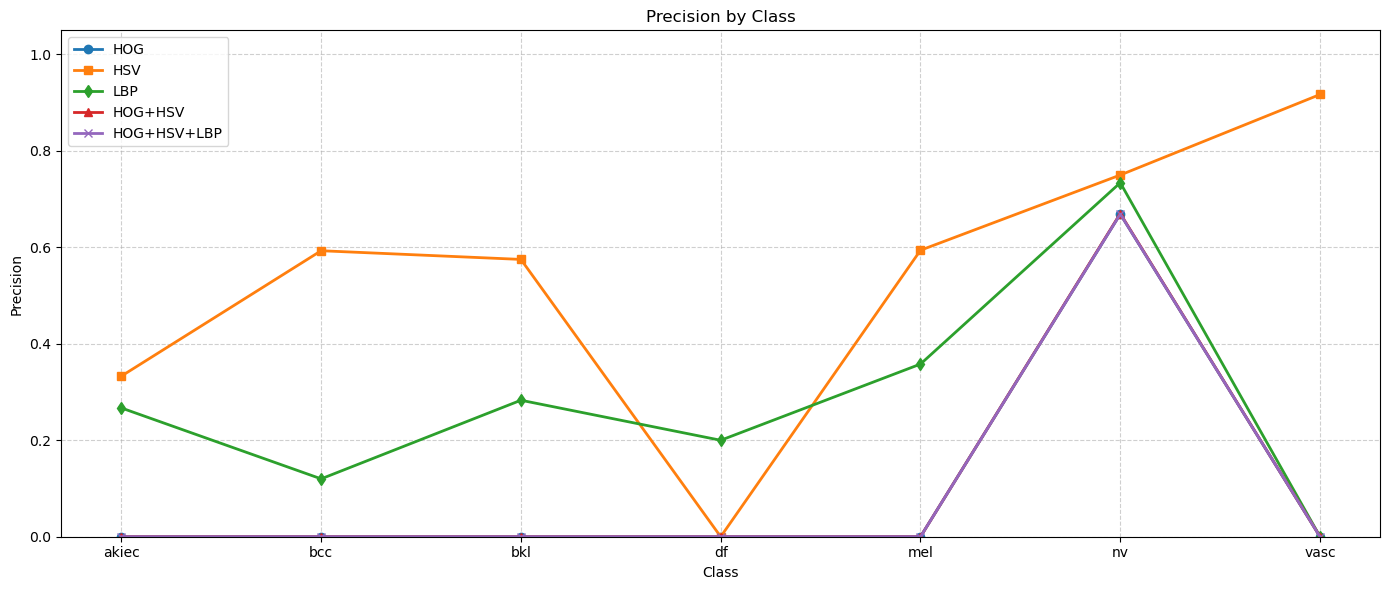

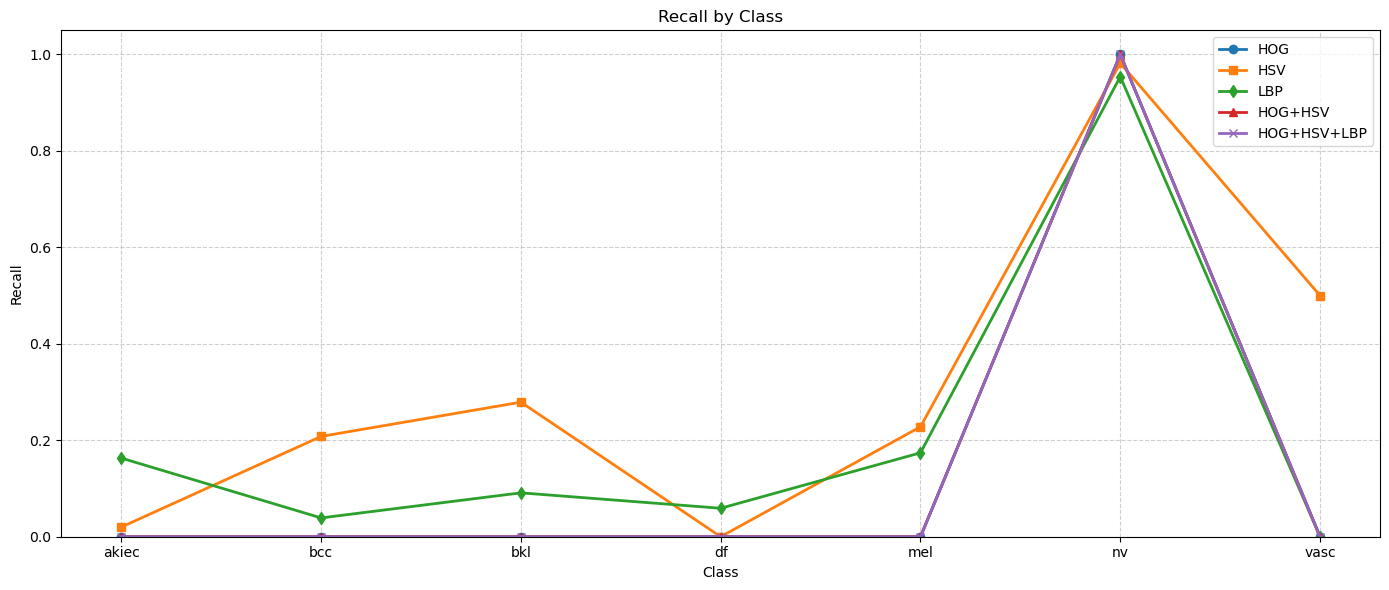

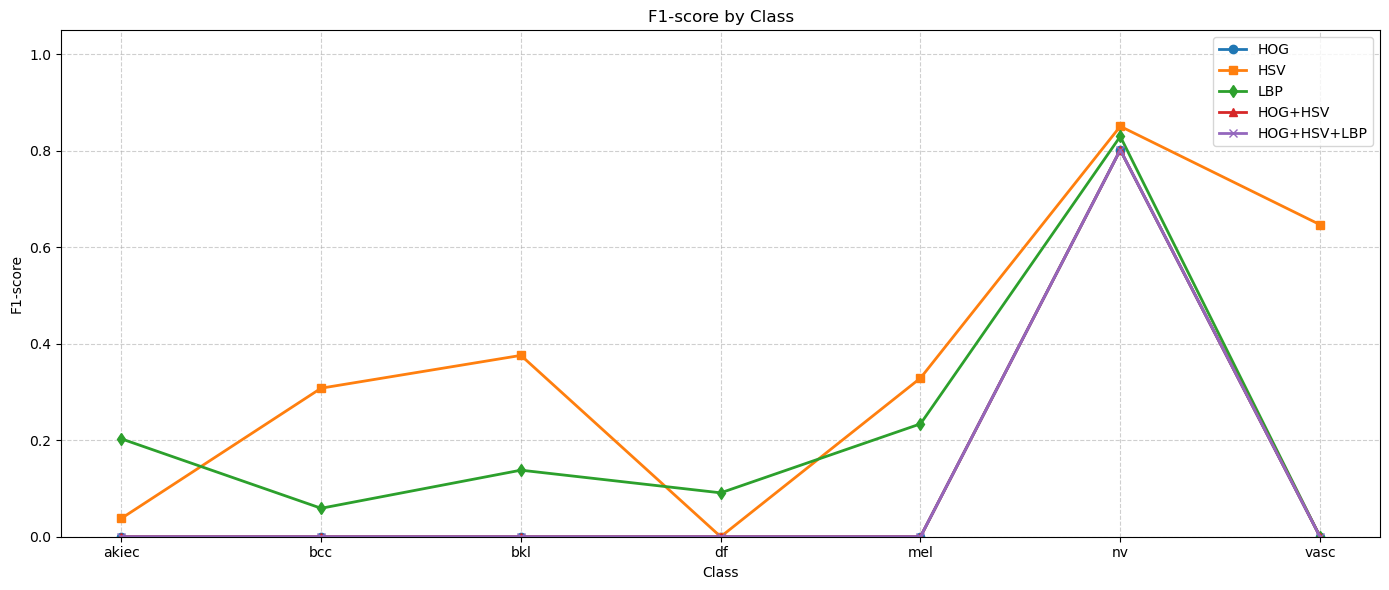

In [17]:
def plot_classwise_metrics(df_hog, df_hsv, df_lbp, df_hog_hsv, df_hog_hsv_lbp):
    metrics = ['precision', 'recall', 'f1-score']

    # Ensure 'class' column exists
    dfs = [df_hog, df_hsv, df_lbp, df_hog_hsv, df_hog_hsv_lbp]
    for i in range(len(dfs)):
        if 'class' not in dfs[i].columns:
            dfs[i] = dfs[i].reset_index().rename(columns={'index': 'class'})

    df_hog, df_hsv, df_lbp, df_hog_hsv, df_hog_hsv_lbp = dfs

    # Extract class labels (assume first 7 are the per-class rows)
    classes = df_hog['class'][:7]

    # Convert only per-class rows to float
    df_hog = df_hog.loc[:6, metrics].astype(float)
    df_hsv = df_hsv.loc[:6, metrics].astype(float)
    df_lbp = df_lbp.loc[:6, metrics].astype(float)
    df_hog_hsv = df_hog_hsv.loc[:6, metrics].astype(float)
    df_hog_hsv_lbp = df_hog_hsv_lbp.loc[:6, metrics].astype(float)

    for metric in metrics:
        plt.figure(figsize=(14, 6))
        plt.plot(classes, df_hog[metric], marker='o', label='HOG', linewidth=2)
        plt.plot(classes, df_hsv[metric], marker='s', label='HSV', linewidth=2)
        plt.plot(classes, df_lbp[metric], marker='d', label='LBP', linewidth=2)
        plt.plot(classes, df_hog_hsv[metric], marker='^', label='HOG+HSV', linewidth=2)
        plt.plot(classes, df_hog_hsv_lbp[metric], marker='x', label='HOG+HSV+LBP', linewidth=2)
        plt.title(f'{metric.capitalize()} by Class')
        plt.xlabel('Class')
        plt.ylabel(metric.capitalize())
        plt.ylim(0, 1.05)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.show()


# Call the function with all 4 reports
plot_classwise_metrics(df_report_hog, df_report_hsv, df_report_lbp, df_report_hog_hsv, df_report_hog_hsv_lbp)

In [18]:
df_report_hog

,precision,recall,f1-score,support
akiec,0.000,0.000,0.000,49.000
bcc,0.000,0.000,0.000,77.000
bkl,0.000,0.000,0.000,165.000
df,0.000,0.000,0.000,17.000
mel,0.000,0.000,0.000,167.000
nv,0.669,1.000,0.802,1006.000
vasc,0.000,0.000,0.000,22.000
accuracy,0.669,0.669,0.669,0.669
macro avg,0.096,0.143,0.115,1503.000
weighted avg,0.448,0.669,0.537,1503.000


In [19]:
df_report_hsv

,precision,recall,f1-score,support
akiec,0.333,0.020,0.038,49.000
bcc,0.593,0.208,0.308,77.000
bkl,0.575,0.279,0.376,165.000
df,0.000,0.000,0.000,17.000
mel,0.594,0.228,0.329,167.000
nv,0.750,0.982,0.851,1006.000
vasc,0.917,0.500,0.647,22.000
accuracy,0.732,0.732,0.732,0.732
macro avg,0.537,0.317,0.364,1503.000
weighted avg,0.686,0.732,0.674,1503.000


In [20]:
df_report_lbp

,precision,recall,f1-score,support
akiec,0.267,0.163,0.203,49.000
bcc,0.120,0.039,0.059,77.000
bkl,0.283,0.091,0.138,165.000
df,0.200,0.059,0.091,17.000
mel,0.358,0.174,0.234,167.000
nv,0.734,0.954,0.830,1006.000
vasc,0.000,0.000,0.000,22.000
accuracy,0.676,0.676,0.676,0.676
macro avg,0.280,0.211,0.222,1503.000
weighted avg,0.579,0.676,0.607,1503.000


In [21]:
df_report_hog_hsv

,precision,recall,f1-score,support
akiec,0.000,0.000,0.000,49.000
bcc,0.000,0.000,0.000,77.000
bkl,0.000,0.000,0.000,165.000
df,0.000,0.000,0.000,17.000
mel,0.000,0.000,0.000,167.000
nv,0.670,1.000,0.802,1006.000
vasc,0.000,0.000,0.000,22.000
accuracy,0.669,0.669,0.669,0.669
macro avg,0.096,0.143,0.115,1503.000
weighted avg,0.448,0.669,0.537,1503.000


In [22]:
df_report_hog_hsv_lbp

,precision,recall,f1-score,support
akiec,0.000,0.000,0.000,49.000
bcc,0.000,0.000,0.000,77.000
bkl,0.000,0.000,0.000,165.000
df,0.000,0.000,0.000,17.000
mel,0.000,0.000,0.000,167.000
nv,0.669,1.000,0.802,1006.000
vasc,0.000,0.000,0.000,22.000
accuracy,0.669,0.669,0.669,0.669
macro avg,0.096,0.143,0.115,1503.000
weighted avg,0.448,0.669,0.537,1503.000
